In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.ticker
import matplotlib.dates

In [2]:
def open_file(path):
    x = np.fromfile(path, dtype='float32')
    x = x[:x.size//3*3]
    x = x.reshape((-1,3))
    start = np.datetime64(path.strip('.3xf32').split('_')[-1])
    time = start + np.timedelta64(100, 'ms') * np.arange(x.shape[0])
    powers = xr.Dataset({'digital' : (['time'], x[:,0]),
                         'cw' : (['time'], x[:,1]),
                         'transponder_noise' : (['time'], x[:,2])},
                        coords = {'time' : time})
    return powers

In [3]:
old_dish = open_file('eshail2_pwr_2019-03-01T17:25:13.532121.3xf32')
new_dish = xr.merge((open_file('eshail2_pwr_2019-03-11T22:05:26.024663.3xf32'),
                     open_file('eshail2_pwr_2019-03-13T21:57:58.867979.3xf32'),
                     open_file('eshail2_pwr_2019-03-13T22:58:18.389283.3xf32')))
noise = open_file('eshail2_pwr_2019-03-13T21:48:27.876786.3xf32')

In [4]:
10*np.log10(noise.mean())

<xarray.Dataset>
Dimensions:            ()
Data variables:
    digital            float64 -53.19
    cw                 float64 -53.18
    transponder_noise  float64 -53.2

In [5]:
10*np.log10(new_dish.mean()) - 10*np.log10(old_dish.mean())

<xarray.Dataset>
Dimensions:            ()
Data variables:
    digital            float64 6.346
    cw                 float64 6.026
    transponder_noise  float64 3.684

In [6]:
def do_plots(powers, ylim, bias = -53.2):
    powers_1min = powers.resample(time = '1min').mean()
    powers_1min_max = powers.resample(time = '1min').max()
    #bias = 10*np.log10(np.average(powers_1min['transponder_noise']))
    
    plt.figure(figsize = (14,8), facecolor = 'w')
    pdB = 10*np.log10(powers_1min) - bias
    for p in pdB.values():
        p.plot()
    (10*np.log10(powers_1min_max['cw']) - bias).plot()
    plt.legend(['Digital', 'CW (average)', 'Transponder noise', 'CW (max)'])
    plt.grid()
    plt.ylabel('Power (dB)')
    plt.xlabel('UTC time')
    plt.title('Power of QO-100 beacons (S+N)/N');
    plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MultipleLocator(1))
    #plt.gca().xaxis.set_major_locator(matplotlib.dates.HourLocator(np.arange(0,24,2)))
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d %H:%M'))
    plt.ylim(ylim)
    
    plt.figure(figsize = (14,8), facecolor = 'w')
    noise_bw = 2000
    noise = 10*np.log10(noise_bw)
    (10*np.log10(powers_1min['digital']-powers_1min['transponder_noise']) - 10*np.log10(powers_1min['transponder_noise'] - 10**(0.1*bias)) + noise).plot()
    (10*np.log10(powers_1min_max['cw']-powers_1min['transponder_noise']) - 10*np.log10(powers_1min['transponder_noise'] - 10**(0.1*bias)) + noise).plot()
    (10*np.log10(powers_1min['digital']-powers_1min['transponder_noise']) - 10*np.log10(powers_1min['transponder_noise']) + noise).plot(color = 'C0', alpha = 0.5)
    (10*np.log10(powers_1min_max['cw']-powers_1min['transponder_noise']) - 10*np.log10(powers_1min['transponder_noise']) + noise).plot(color = 'C1', alpha = 0.5)
    plt.grid()
    plt.ylabel('CN0 (dB-Hz)')
    plt.xlabel('UTC time')
    plt.title('CN0 of QO-100 beacons');
    plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MultipleLocator(1))
    #plt.gca().xaxis.set_major_locator(matplotlib.dates.HourLocator(np.arange(0,24,2)))
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d %H:%M'))
    plt.ylim([40,55]);
    plt.legend(['Digital (at transponder)', 'CW (max) (at transponder)', 'Digital (at receiver)', 'CW (max) (at receiver)']);
    
    plt.figure(figsize = (14,8), facecolor = 'w')
    (10*np.log10(powers_1min['transponder_noise'] - 10**(0.1*bias)) - bias).plot()
    plt.grid()
    plt.ylabel('S/N (dB-Hz)')
    plt.xlabel('UTC time')
    plt.title('S/N of QO-100 NB transponder noise');
    plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MultipleLocator(1))
    #plt.gca().xaxis.set_major_locator(matplotlib.dates.HourLocator(np.arange(0,24,2)))
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d %H:%M'))
    plt.ylim([-3,8]);

/home/daniel/.local/lib64/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


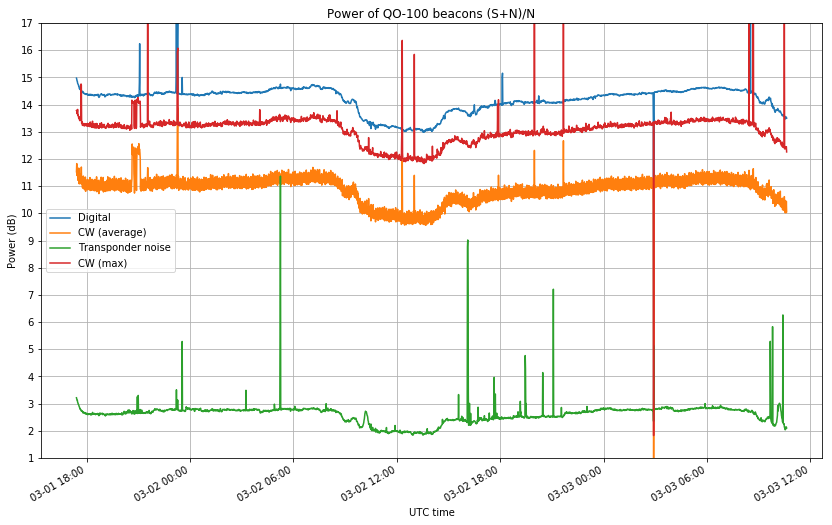

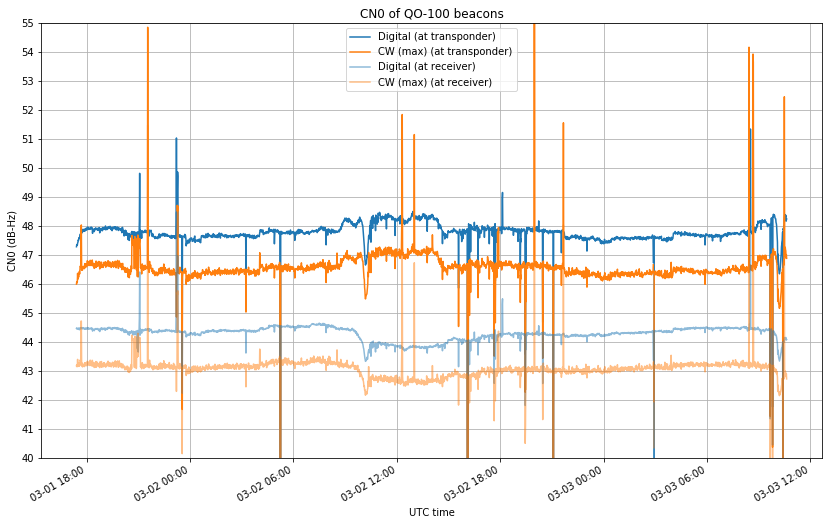

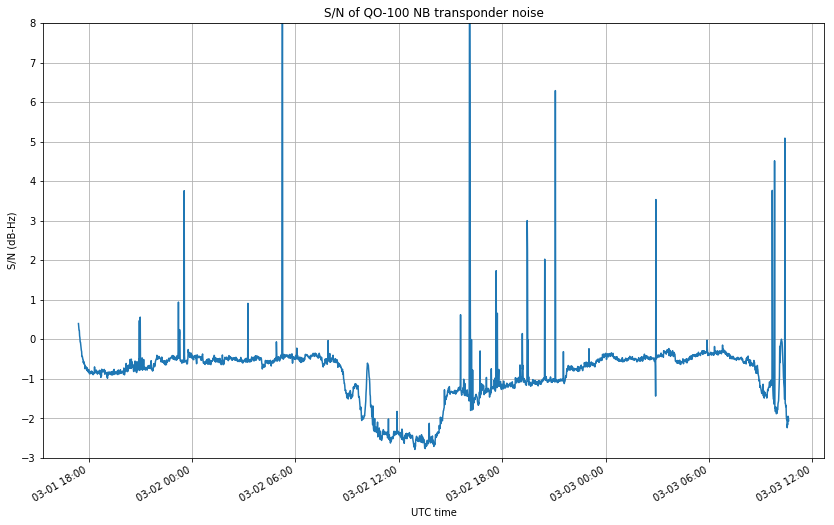

In [7]:
do_plots(old_dish, ylim = (1,17))

/home/daniel/.local/lib64/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


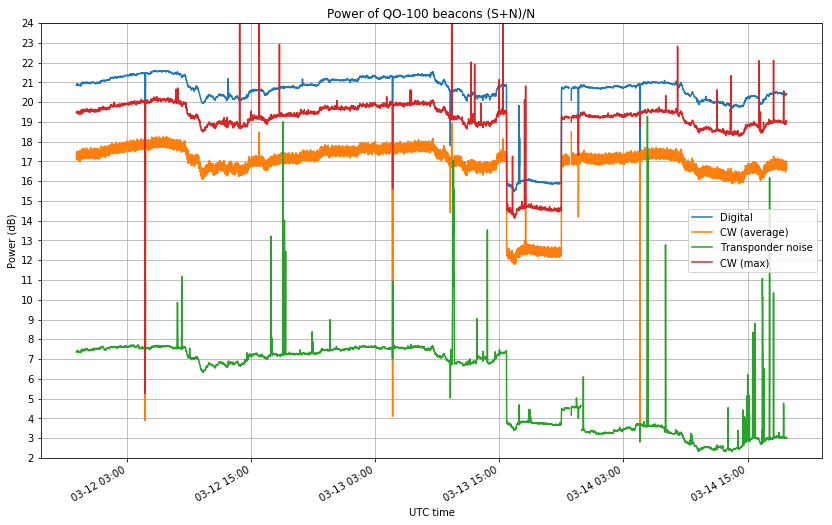

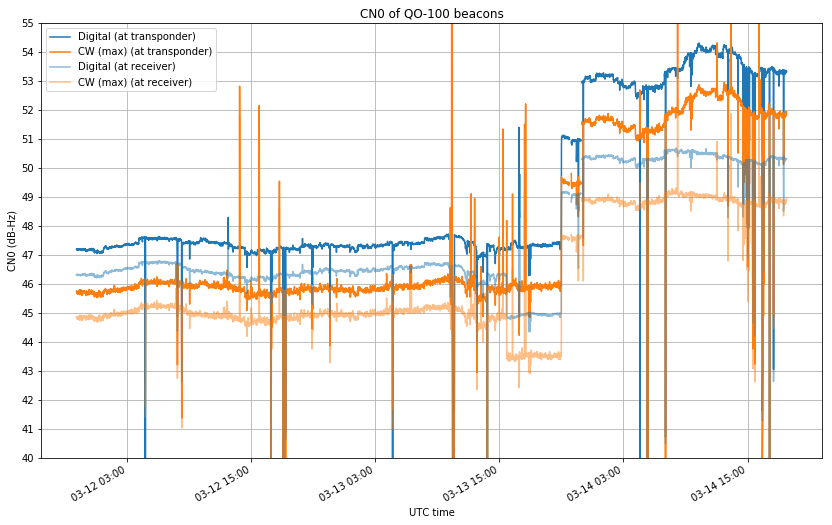

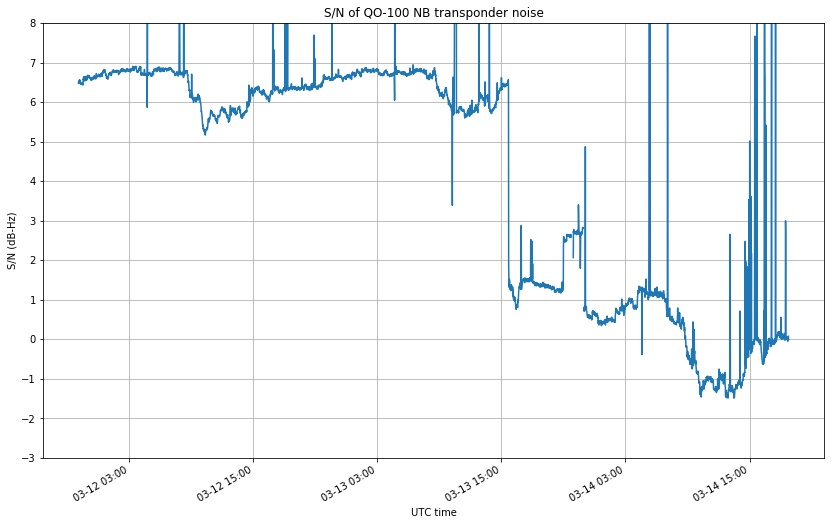

In [8]:
do_plots(new_dish, ylim = (2,24))